In [81]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

#!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
#!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install warnings
!pip install dgl
!pip install texttable

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")
print(device)

2.0.1+cu118
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu


In [82]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data
import scipy
import pickle
from skimage.segmentation import slic
from torchvision import datasets
import multiprocessing as mp
from torch_geometric.utils import from_networkx,to_networkx
from torch.utils.data import random_split
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, BatchNorm, global_mean_pool
from torch_geometric.utils import softmax, degree

#/content/drive/MyDrive/Colab_Notebooks
import os
import random
import numpy as np
import os.path as osp
from torch.autograd import grad
from drive.MyDrive.Colab_Notebooks.DIR_GNN.utils.mask import set_masks, clear_masks
from drive.MyDrive.Colab_Notebooks.DIR_GNN.utils.logger import Logger
from datetime import datetime
from drive.MyDrive.Colab_Notebooks.DIR_GNN.utils.helper import random_partition, set_seed
from drive.MyDrive.Colab_Notebooks.DIR_GNN.utils.get_subgraph import split_graph, relabel
import scipy.ndimage
import scipy.spatial
import argparse
import datetime
import networkx as nx
import dgl
import os
import pickle
from scipy.spatial.distance import cdist
import numpy as np
import itertools

import csv
from sklearn.model_selection import StratifiedShuffleSplit
import random
from torchvision import transforms, datasets

import time

from scipy import ndimage



import torch


import matplotlib.pyplot as plt
import matplotlib


In [83]:
import os.path as osp

import torch
import torch.nn as nn
from torch.nn import ModuleList
import torch.nn.functional as F
from torch.nn import Sequential as Seq, ReLU, Tanh, Linear as Lin, Softmax
from torch_geometric.nn import GraphConv, BatchNorm, global_max_pool,LEConv, BatchNorm, fps

class MNISTSPNet(torch.nn.Module):

    def __init__(self, in_channels, hid_channels=32, num_classes=3, conv_unit=2):
        super(MNISTSPNet, self).__init__()

        self.node_emb = Lin(in_channels, hid_channels)

        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        self.relus = ModuleList()

        for i in range(conv_unit):
            conv = GraphConv(in_channels=hid_channels, out_channels=hid_channels)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(hid_channels))
            self.relus.append(ReLU())

        self.causal_mlp = nn.Sequential(
            nn.Linear(hid_channels, 2*hid_channels),
            nn.ReLU(),
            nn.Linear(2*hid_channels, num_classes)
        )
        
        self.conf_mlp = torch.nn.Sequential(
            nn.Linear(hid_channels, 2*hid_channels),
            ReLU(),
            nn.Linear(2*hid_channels, num_classes)
        )

    def forward(self, x, edge_index, edge_attr, batch):
        node_x = self.get_node_reps(x, edge_index, edge_attr, batch)
        graph_x = global_max_pool(node_x, batch)
        return self.get_causal_pred(graph_x)
    
    def get_node_reps(self, x, edge_index, edge_attr, batch):
        edge_weight = edge_attr.view(-1)
        x = self.node_emb(x)
        for conv, batch_norm, ReLU in \
                zip(self.convs, self.batch_norms, self.relus):
            x = conv(x, edge_index, edge_weight=edge_weight)
            x = ReLU(batch_norm(x))
        node_x = x
        return node_x
    
    def get_graph_rep(self, x, edge_index, edge_attr, batch):

        node_x = self.get_node_reps(x, edge_index, edge_attr, batch)
        graph_x = global_max_pool(node_x, batch)
        return graph_x

    def get_causal_pred(self, causal_graph_x):
        pred = self.causal_mlp(causal_graph_x)
        return pred

    def get_conf_pred(self, conf_graph_x):
        pred = self.conf_mlp(conf_graph_x)
        return pred

    def get_comb_pred(self, causal_graph_x, conf_graph_x):
        causal_pred = self.causal_mlp(causal_graph_x)
        conf_pred = self.conf_mlp(conf_graph_x).detach()
        return torch.sigmoid(conf_pred)*causal_pred

In [84]:
class CausalAttNet(nn.Module):
    
    def __init__(self, causal_ratio,out_channels):
        super(CausalAttNet, self).__init__()
        self.conv1 = GraphConv(in_channels=1,out_channels=out_channels)
        self.conv2 = GraphConv(in_channels=out_channels, out_channels=out_channels)
        self.mlp = nn.Sequential(
            nn.Linear(out_channels*2, out_channels*4),
            nn.ReLU(),
            nn.Linear(out_channels*4, 1)
        )
        self.ratio = causal_ratio
    def forward(self, data):
        x = F.relu(self.conv1(data.x.to(torch.float32),data.edge_index, data.edge_attr.view(-1)))
        x = self.conv2(x, data.edge_index, data.edge_attr.view(-1))

        row, col = data.edge_index
        edge_rep = torch.cat([x[row], x[col]], dim=-1)
        edge_score = self.mlp(edge_rep).view(-1)

        (causal_edge_index, causal_edge_attr, causal_edge_weight), \
        (conf_edge_index, conf_edge_attr, conf_edge_weight) = split_graph(data,edge_score, self.ratio)

        causal_x, causal_edge_index, causal_batch, _ = relabel(x, causal_edge_index, data.batch)
        conf_x, conf_edge_index, conf_batch, _ = relabel(x, conf_edge_index, data.batch)

        return (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
                (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch),\
                edge_score

In [85]:
import torch
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import DataLoader, DenseDataLoader as DenseLoader
from torch import tensor
import torch_geometric.transforms as T
from torch.optim.lr_scheduler import CosineAnnealingLR, MultiStepLR
import pdb
import random
import numpy as np
from torch.autograd import grad
from torch_geometric.data import Batch
import networkx as nx
from torch_geometric.utils import to_networkx


def generate_node_feature(data):
  num_edges = data.edge_index.shape[1]
  edge_attr = torch.full((num_edges, 1), 1.0)
  G = to_networkx(data, to_undirected=True) # Convert to networkx graph

  # Calculate eigenvector centrality
  centrality = nx.eigenvector_centrality_numpy(G)

  # Convert the centrality dictionary to a list maintaining the order of nodes
  node_features = [centrality[node] for node in G.nodes]

  # Convert to tensor
  node_features=torch.tensor(node_features, dtype=torch.float).view(-1, 1)
  
  return node_features,edge_attr
from torch_geometric.datasets import TUDataset
import os.path as osp
from torch.utils.data import random_split
from torch_geometric.datasets import TUDataset
path ='/content/drive/MyDrive/'
# Load the COLLAB dataset
dataset = TUDataset(root='/content/drive/MyDrive/', name='COLLAB')

# Print some information about the dataset
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the first graph in the dataset
data = dataset[1]

print('\nFirst graph in the dataset:')
print('======================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {"Yes" if data.contains_isolated_nodes() else "No"}')
print(f'Contains self-loops: {"Yes" if data.contains_self_loops() else "No"}')
print(f'Is undirected: {"Yes" if data.is_undirected() else "No"}')

train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.15)
test_size = len(dataset) - train_size - val_size
print(f'training size:{train_size}')
print(f'valating size:{val_size}')
print(f'testing size:{test_size}')

# Generate the splits
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])
training=[]
valating=[]
testing=[]
for data in train_dataset:
  data.x,data.edge_attr=generate_node_feature(data)
  training.append(data)
for data in val_dataset:
  data.x,data.edge_attr=generate_node_feature(data)
  valating.append(data)
for data in test_dataset:
  data.x,data.edge_attr=generate_node_feature(data)
  testing.append(data)
print(f'training size:{len(training)}')
print(f'valating size:{len(valating)}')
print(f'testing size:{len(testing)}')


Dataset: COLLAB(5000):
Number of graphs: 5000
Number of features: 0
Number of classes: 3

First graph in the dataset:
Number of nodes: 52
Number of edges: 2188
Average node degree: 42.08
Contains isolated nodes: No
Contains self-loops: No
Is undirected: Yes
training size:3500
valating size:750
testing size:750
training size:3500
valating size:750
testing size:750


In [86]:
training[0]

Data(edge_index=[2, 56926], y=[1], num_nodes=243, x=[243, 1], edge_attr=[56926, 1])

In [87]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
#Epoch=2
#alpha_prime = 1e-4 * (Epoch ** 1.6)
causal_ratio=0.8
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")
g = MNISTSPNet(32).to(device)
att_net = CausalAttNet(causal_ratio,32).to(device)
model_optimizer = torch.optim.Adam(
            list(g.parameters()) +
            list(att_net.parameters()),
            lr=0.001)
conf_opt = torch.optim.Adam(g.conf_mlp.parameters(), lr=0.001)
CELoss = nn.CrossEntropyLoss(reduction="mean")
train_loader = DataLoader(training, batch_size=32, shuffle=True)
val_loader = DataLoader(valating, batch_size=32, shuffle=False)
test_loader = DataLoader(testing, batch_size=1, shuffle=False)
EXp=500


In [88]:
import time
import json

loss_value=[]
loss_value_valation=[]
from tqdm import tqdm
for epoch in range(EXp):
  g.train()
  att_net.train()
  all_loss, n_bw, all_env_loss = 0, 0, 0
  all_causal_loss, all_conf_loss = 0, 0
  causal_edge_weights = torch.tensor([]).to(device)
  conf_edge_weights = torch.tensor([]).to(device)
  alpha_prime = 1e-4 * (epoch ** 1.6)
  dummy_w = nn.Parameter(torch.Tensor([1.0])).to(device)
  print(f"-----training-------{epoch}")
  loop = tqdm(enumerate(train_loader),total=len(train_loader))
  for it, graph in loop:
      graph.to(device)
      n_bw += 1
      N = graph.num_graphs
      (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
      (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)

      set_masks(causal_edge_weight, g)
      causal_rep = g.get_graph_rep(x=causal_x, edge_index=causal_edge_index,edge_attr=causal_edge_attr, batch=causal_batch)
      causal_out = g.get_causal_pred(causal_rep)
      #print(causal_out)
      clear_masks(g)
      set_masks(conf_edge_weight, g)
      conf_rep = g.get_graph_rep(
          x=conf_x, edge_index=conf_edge_index, 
          edge_attr=conf_edge_attr, batch=conf_batch).detach()
      conf_out = g.get_conf_pred(conf_rep)
      clear_masks(g)
      #y=to01(graph.y).to(device)
      #print(conf_out)
      causal_loss = CELoss(causal_out,graph.y)
      #print(causal_loss)
      
      uniform_target = torch.ones_like(causal_out, dtype=torch.float).to(device) / 4
      conf_loss = CELoss(conf_out,uniform_target)
      #print('noncausal',float(conf_loss))
      #all_conf_loss += conf_loss
      #all_causal_loss += causal_loss
      #all_env_loss += env_loss
      #print(all_causal_loss)
      env_loss = 0
                
                
      env_loss = torch.tensor([]).to(device)
      for conf in conf_rep:
          rep_out = g.get_comb_pred(causal_rep, conf)
          env_loss = torch.cat([env_loss, CELoss(rep_out, graph.y).unsqueeze(0)])
      causal_loss += min(alpha_prime, 1) * env_loss.mean()
      env_loss = alpha_prime * torch.var(env_loss * conf_rep.size(0))

      all_conf_loss += conf_loss
      all_causal_loss += causal_loss
      all_env_loss += env_loss
      causal_edge_weights = torch.cat([causal_edge_weights, causal_edge_weight])
      conf_edge_weights = torch.cat([conf_edge_weights, conf_edge_weight])

  all_env_loss /= n_bw
  all_causal_loss /= n_bw
  all_conf_loss /= n_bw
  all_loss = all_causal_loss + all_env_loss

  loss_value.append(all_loss.item())
  print(f'number of {epoch} of all loss:{all_loss}')
  conf_opt.zero_grad()
  all_conf_loss.backward()
  conf_opt.step()

  model_optimizer.zero_grad()
  all_loss.backward()
  model_optimizer.step()

  with torch.no_grad():
    g.eval()
    att_net.eval()
    acc = 0
    for graph in val_loader: 
        graph.to(device)
        (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
        (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)
        set_masks(causal_edge_weight, g)
        out = g(x=causal_x, edge_index=causal_edge_index, 
                edge_attr=causal_edge_attr, batch=causal_batch)
        clear_masks(g)
        acc += torch.sum(out.argmax(-1).view(-1) == graph.y.view(-1))
    acc = float(acc) / len(val_loader.dataset)
    loss_value_valation.append(acc)
    print(f"causal val accuracy:{acc}")
    dictionary={"number of epoch":epoch,
                "training loss list":loss_value,
                "valation accuracy list":loss_value_valation}

    # Serializing json
    json_object = json.dumps(dictionary,indent=3)
    
    # Writing to sample.json
    with open("/content/drive/MyDrive/running_RQ2/COLLAB/DIR/DIR.json", "w") as outfile:
        outfile.write(json_object)

    torch.save({
            'causal_model': att_net.state_dict(),
            'predictco': g.state_dict(),
            'model_optimizer':model_optimizer.state_dict(),
            'conf_opt':conf_opt.state_dict()
            }, '/content/drive/MyDrive/running_RQ2/COLLAB/DIR/allmodel_DIR.pt')
    if(epoch>50):
      check=abs(acc-loss_value_valation[len(loss_value_valation)-20])/20
      if(check<=0.001):
        break

g.eval()
att_net.eval()
acc = 0
for graph in val_loader: 
  graph.to(device)
  (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
  (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)
  set_masks(causal_edge_weight, g)
  out = g(x=causal_x, edge_index=causal_edge_index, 
          edge_attr=causal_edge_attr, batch=causal_batch)
  clear_masks(g)
  acc += torch.sum(out.argmax(-1).view(-1) == graph.y.view(-1))
acc = float(acc) / len(val_loader.dataset)
loss_value_valation.append(acc)
print(f"causal test accuracy:{acc}")
dictionary={"number of epoch":epoch,
            "training loss list":loss_value,
            "valation accuracy list":loss_value_valation,
            "test accuracy value":acc}
 
# Serializing json
json_object = json.dumps(dictionary,indent=4)

# Writing to sample.json
with open("/content/drive/MyDrive/running_RQ2/COLLAB/DIR/DIR.json", "w") as outfile:
    outfile.write(json_object)


      





''' conf_opt.zero_grad()
all_conf_loss.backward()
conf_opt.step()

model_optimizer.zero_grad()
all_loss.backward()
model_optimizer.step()'''





-----training-------0


100%|██████████| 110/110 [00:18<00:00,  5.82it/s]


number of 0 of all loss:1.0419723987579346
causal val accuracy:0.528
-----training-------1


100%|██████████| 110/110 [00:15<00:00,  7.01it/s]


number of 1 of all loss:1.0401567220687866
causal val accuracy:0.528
-----training-------2


100%|██████████| 110/110 [00:16<00:00,  6.85it/s]


number of 2 of all loss:1.02420973777771
causal val accuracy:0.528
-----training-------3


100%|██████████| 110/110 [00:15<00:00,  7.06it/s]


number of 3 of all loss:1.0114542245864868
causal val accuracy:0.528
-----training-------4


100%|██████████| 110/110 [00:15<00:00,  7.01it/s]


number of 4 of all loss:0.9978337287902832
causal val accuracy:0.528
-----training-------5


100%|██████████| 110/110 [00:15<00:00,  7.05it/s]


number of 5 of all loss:1.0009081363677979
causal val accuracy:0.528
-----training-------6


100%|██████████| 110/110 [00:15<00:00,  7.16it/s]


number of 6 of all loss:0.9968394041061401
causal val accuracy:0.528
-----training-------7


100%|██████████| 110/110 [00:16<00:00,  6.57it/s]


number of 7 of all loss:1.0011475086212158
causal val accuracy:0.528
-----training-------8


100%|██████████| 110/110 [00:17<00:00,  6.22it/s]


number of 8 of all loss:0.995003879070282
causal val accuracy:0.528
-----training-------9


100%|██████████| 110/110 [00:15<00:00,  6.91it/s]


number of 9 of all loss:0.9843759536743164
causal val accuracy:0.528
-----training-------10


100%|██████████| 110/110 [00:15<00:00,  6.97it/s]


number of 10 of all loss:0.984430193901062
causal val accuracy:0.528
-----training-------11


100%|██████████| 110/110 [00:16<00:00,  6.78it/s]


number of 11 of all loss:0.979934811592102
causal val accuracy:0.528
-----training-------12


100%|██████████| 110/110 [00:15<00:00,  6.95it/s]


number of 12 of all loss:0.9757252931594849
causal val accuracy:0.528
-----training-------13


100%|██████████| 110/110 [00:15<00:00,  6.98it/s]


number of 13 of all loss:0.983572781085968
causal val accuracy:0.528
-----training-------14


100%|██████████| 110/110 [00:15<00:00,  6.91it/s]


number of 14 of all loss:0.9670141339302063
causal val accuracy:0.528
-----training-------15


100%|██████████| 110/110 [00:15<00:00,  6.90it/s]


number of 15 of all loss:0.9638139009475708
causal val accuracy:0.5786666666666667
-----training-------16


100%|██████████| 110/110 [00:15<00:00,  6.99it/s]


number of 16 of all loss:0.9552677869796753
causal val accuracy:0.5786666666666667
-----training-------17


100%|██████████| 110/110 [00:15<00:00,  7.03it/s]


number of 17 of all loss:0.958626389503479
causal val accuracy:0.5786666666666667
-----training-------18


100%|██████████| 110/110 [00:15<00:00,  7.10it/s]


number of 18 of all loss:0.9576343894004822
causal val accuracy:0.5786666666666667
-----training-------19


100%|██████████| 110/110 [00:15<00:00,  7.02it/s]


number of 19 of all loss:0.949322521686554
causal val accuracy:0.5786666666666667
-----training-------20


100%|██████████| 110/110 [00:15<00:00,  7.00it/s]


number of 20 of all loss:0.9503306746482849
causal val accuracy:0.5786666666666667
-----training-------21


100%|██████████| 110/110 [00:15<00:00,  7.00it/s]


number of 21 of all loss:0.9473246335983276
causal val accuracy:0.5786666666666667
-----training-------22


100%|██████████| 110/110 [00:16<00:00,  6.81it/s]


number of 22 of all loss:0.9464429020881653
causal val accuracy:0.5786666666666667
-----training-------23


100%|██████████| 110/110 [00:15<00:00,  7.01it/s]


number of 23 of all loss:0.9381772875785828
causal val accuracy:0.5786666666666667
-----training-------24


100%|██████████| 110/110 [00:15<00:00,  7.10it/s]


number of 24 of all loss:0.9414225816726685
causal val accuracy:0.5786666666666667
-----training-------25


100%|██████████| 110/110 [00:16<00:00,  6.76it/s]


number of 25 of all loss:0.9423419237136841
causal val accuracy:0.5786666666666667
-----training-------26


100%|██████████| 110/110 [00:15<00:00,  6.95it/s]


number of 26 of all loss:0.9342475533485413
causal val accuracy:0.5786666666666667
-----training-------27


100%|██████████| 110/110 [00:15<00:00,  6.98it/s]


number of 27 of all loss:0.9360915422439575
causal val accuracy:0.5786666666666667
-----training-------28


100%|██████████| 110/110 [00:15<00:00,  6.98it/s]


number of 28 of all loss:0.9450501203536987
causal val accuracy:0.5786666666666667
-----training-------29


100%|██████████| 110/110 [00:15<00:00,  7.00it/s]


number of 29 of all loss:0.9326430559158325
causal val accuracy:0.5786666666666667
-----training-------30


100%|██████████| 110/110 [00:15<00:00,  7.14it/s]


number of 30 of all loss:0.9374722242355347
causal val accuracy:0.5786666666666667
-----training-------31


100%|██████████| 110/110 [00:15<00:00,  7.08it/s]


number of 31 of all loss:0.9408062696456909
causal val accuracy:0.5786666666666667
-----training-------32


100%|██████████| 110/110 [00:15<00:00,  7.00it/s]


number of 32 of all loss:0.9348434209823608
causal val accuracy:0.5786666666666667
-----training-------33


100%|██████████| 110/110 [00:15<00:00,  6.96it/s]


number of 33 of all loss:0.9204427599906921
causal val accuracy:0.5786666666666667
-----training-------34


100%|██████████| 110/110 [00:16<00:00,  6.83it/s]


number of 34 of all loss:0.9510242938995361
causal val accuracy:0.5786666666666667
-----training-------35


100%|██████████| 110/110 [00:15<00:00,  7.14it/s]


number of 35 of all loss:0.958540678024292
causal val accuracy:0.5786666666666667
-----training-------36


100%|██████████| 110/110 [00:15<00:00,  7.01it/s]


number of 36 of all loss:0.9872497320175171
causal val accuracy:0.5786666666666667
-----training-------37


100%|██████████| 110/110 [00:15<00:00,  7.08it/s]


number of 37 of all loss:0.9674187302589417
causal val accuracy:0.5786666666666667
-----training-------38


100%|██████████| 110/110 [00:15<00:00,  6.99it/s]


number of 38 of all loss:0.9678177237510681
causal val accuracy:0.5786666666666667
-----training-------39


100%|██████████| 110/110 [00:15<00:00,  6.98it/s]


number of 39 of all loss:0.9661538600921631
causal val accuracy:0.5786666666666667
-----training-------40


100%|██████████| 110/110 [00:15<00:00,  7.12it/s]


number of 40 of all loss:0.9707962870597839
causal val accuracy:0.5786666666666667
-----training-------41


100%|██████████| 110/110 [00:15<00:00,  7.12it/s]


number of 41 of all loss:0.9552266597747803
causal val accuracy:0.5786666666666667
-----training-------42


100%|██████████| 110/110 [00:15<00:00,  7.02it/s]


number of 42 of all loss:0.9569921493530273
causal val accuracy:0.5786666666666667
-----training-------43


100%|██████████| 110/110 [00:15<00:00,  7.01it/s]


number of 43 of all loss:0.948320209980011
causal val accuracy:0.5786666666666667
-----training-------44


100%|██████████| 110/110 [00:15<00:00,  7.08it/s]


number of 44 of all loss:0.9566561579704285
causal val accuracy:0.5786666666666667
-----training-------45


100%|██████████| 110/110 [00:15<00:00,  7.08it/s]


number of 45 of all loss:0.9621066451072693
causal val accuracy:0.5786666666666667
-----training-------46


100%|██████████| 110/110 [00:15<00:00,  7.15it/s]


number of 46 of all loss:0.9481321573257446
causal val accuracy:0.5786666666666667
-----training-------47


100%|██████████| 110/110 [00:15<00:00,  6.89it/s]


number of 47 of all loss:0.9570515751838684
causal val accuracy:0.5786666666666667
-----training-------48


100%|██████████| 110/110 [00:15<00:00,  6.97it/s]


number of 48 of all loss:0.9652844071388245
causal val accuracy:0.5786666666666667
-----training-------49


100%|██████████| 110/110 [00:15<00:00,  7.10it/s]


number of 49 of all loss:0.9703368544578552
causal val accuracy:0.5786666666666667
-----training-------50


100%|██████████| 110/110 [00:15<00:00,  6.99it/s]


number of 50 of all loss:0.9666992425918579
causal val accuracy:0.5786666666666667
-----training-------51


100%|██████████| 110/110 [00:15<00:00,  6.99it/s]


number of 51 of all loss:0.9764091968536377
causal val accuracy:0.5786666666666667
causal test accuracy:0.572


' conf_opt.zero_grad()\nall_conf_loss.backward()\nconf_opt.step()\n\nmodel_optimizer.zero_grad()\nall_loss.backward()\nmodel_optimizer.step()'

In [89]:
'''test_loader = DataLoader(testing_final, batch_size=1, shuffle=False)

g.eval()
att_net.eval()
acc = 0
for graph in test_loader: 
  graph.to(device)
  (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
  (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)
  set_masks(causal_edge_weight, g)
  out = g(x=causal_x, edge_index=causal_edge_index, 
          edge_attr=causal_edge_attr, batch=causal_batch)
  clear_masks(g)
  acc += torch.sum(out.argmax(-1).view(-1) == graph.y.view(-1))
acc = float(acc) / len(test_loader.dataset)
loss_value_valation.append(acc)
print(f"causal test accuracy:{acc}")
dictionary={"number of epoch":epoch,
            "training loss list":loss_value,
            "valation accuracy list":loss_value_valation,
            "test accuracy value":acc}
 
# Serializing json
json_object = json.dumps(dictionary,indent=4)

# Writing to sample.json
with open("/content/drive/MyDrive/running_dir_mnist/numberDIR_tl_va_e08.json", "w") as outfile:
    outfile.write(json_object)

'''
      




'test_loader = DataLoader(testing_final, batch_size=1, shuffle=False)\n\ng.eval()\natt_net.eval()\nacc = 0\nfor graph in test_loader: \n  graph.to(device)\n  (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),  (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)\n  set_masks(causal_edge_weight, g)\n  out = g(x=causal_x, edge_index=causal_edge_index, \n          edge_attr=causal_edge_attr, batch=causal_batch)\n  clear_masks(g)\n  acc += torch.sum(out.argmax(-1).view(-1) == graph.y.view(-1))\nacc = float(acc) / len(test_loader.dataset)\nloss_value_valation.append(acc)\nprint(f"causal test accuracy:{acc}")\ndictionary={"number of epoch":epoch,\n            "training loss list":loss_value,\n            "valation accuracy list":loss_value_valation,\n            "test accuracy value":acc}\n \n# Serializing json\njson_object = json.dumps(dictionary,indent=4)\n\n# Writing to sample.json\nwith open("/content/drive/M

In [90]:
acc

0.572

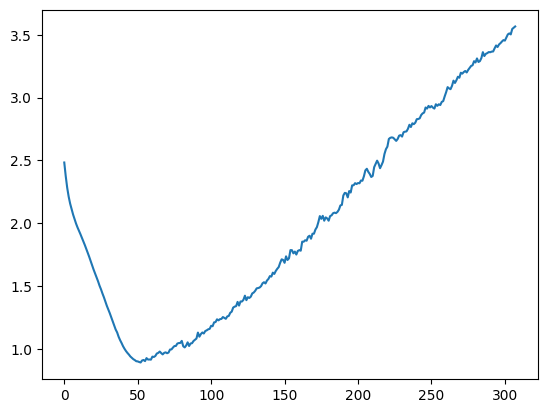

In [91]:
import json
f = open('/content/drive/MyDrive/running_dir_mnist/numberDIR_tl_va_e095.json')
data = json.load(f)
#l=data['training loss list']
y081 = np.array(data['training loss list'])
plt.plot(y081)
plt.show()

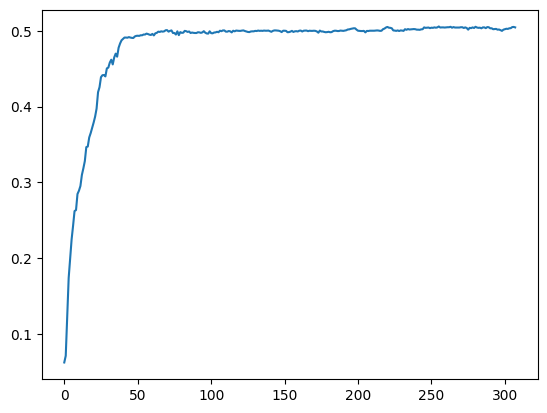

In [92]:
y082 = np.array(data['valation accuracy list'])
plt.plot(y082)
plt.show()

In [93]:
torch.save(att_net.state_dict(),'/content/drive/MyDrive/Colab_Notebooks/dir0123causl.pt')
torch.save(g.state_dict(),'/content/drive/MyDrive/Colab_Notebooks/dir0123pred.pt')

In [94]:
new=[]
for i in range(len(l)):
  new.append(float(l[i]))
line=np.array(new)
plt.plot(line)
plt.show()

NameError: ignored

In [ ]:
t2=DataLoader(training_final[20000:], batch_size=1, shuffle=False)
t2_load=[]
for i in t2:
  t2_load.append(i)

In [ ]:
len(t2_load)

In [ ]:
causal_acc=0
conf_acc=0
n_test_data=0
for graph in t2_load: 
  graph.to(device)
  n_test_data+=1
  

  (causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
  (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(graph)
  
  set_masks(causal_edge_weight, g)
  causal_out = g(
      x=causal_x, edge_index=causal_edge_index, 
      edge_attr=causal_edge_attr, batch=causal_batch)
  set_masks(conf_edge_weight, g)
  conf_out = g(x=conf_x, edge_index=conf_edge_index, 
          edge_attr=conf_edge_attr, batch=conf_batch)
  clear_masks(g)
  causal_acc += torch.sum(causal_out.argmax(-1).view(-1) == graph.y.view(-1)) 
  conf_acc += torch.sum(conf_out.argmax(-1).view(-1) == graph.y.view(-1)) 
        
        

In [ ]:
causal_acc/4754

In [ ]:
#newdata_with_feat_knn=[]
for i in range(len(data_with_feat_knn.labels)):
  if(data_with_feat_knn[i][1]==0):
    sp_data=data_with_feat_knn.sp_data[i]
    adj_matrix=data_with_feat_knn.Adj_matrices[i]
    label=data_with_feat_knn[i][1]
    feat_coord=data_with_feat_knn.use_feat_for_graph
    break


In [ ]:
sp_data[1].shape

In [ ]:

t1=DataLoader(new_012, batch_size=1, shuffle=False)
t_load=[]
for i in t1:
  t_load.append(i)

In [ ]:
idex=0
(causal_x, causal_edge_index, causal_edge_attr, causal_edge_weight, causal_batch),\
      (conf_x, conf_edge_index, conf_edge_attr, conf_edge_weight, conf_batch), edge_score = att_net(t_load[idex].to(device))

In [ ]:
t_load[0]

In [ ]:
causal_node=np.array(torch.unique(causal_edge_index).cpu())
print(causal_node)

In [ ]:
causal_node=np.array(torch.unique(causal_edge_index).cpu())
print(causal_node)

In [ ]:
ncausal_node=np.array(torch.unique(conf_edge_index).cpu())
print(ncausal_node)

In [ ]:
conf_x.detach().numpy().sum(axis=1)

In [ ]:
plt.imshow(training_data_01[idex])
print("Label: ",training_label_01[idex])

In [ ]:
sample = np.random.choice(len(data_with_feat_knn))
g_sample = data_with_feat_knn[idex][0]
print("Label: ", data_with_feat_knn[idex][1])
nx.draw(g_sample.to_networkx(), with_labels=True)
plt.show()

In [ ]:
import networkx as nx
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams
def plot_superpixels_graph(sp_data, adj_matrix, label, feat_coord, with_edges,real,conf_x):
    Y = squareform(pdist(sp_data[1], 'euclidean'))
    x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
    #intensities = sp_data[0].mean(axis=1)
    #label = classes[label]
    if real:
      intensities = sp_data[0].mean(axis=1)
    else:
      intensities=np.array([0]*sp_data[0].shape[0])
      intensities[ncausal_node]=conf_x.detach().numpy()
      #intensities=np.array(conf_x.sum(dim=1).cpu().detach())



    
    G = nx.from_numpy_array(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree
    
    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
    
    


In [ ]:

#sp_data=data_with_feat_knn.sp_data[idex]
#adj_matrix=data_with_feat_knn.Adj_matrices[idex]
#label=data_with_feat_knn[idex][1]
#feat_coord=data_with_feat_knn.use_feat_for_graph
Y = squareform(pdist(sp_data[1], 'euclidean'))
x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
#intensities = sp_data[0].mean(axis=1)
#label = classes[label]


intensities=np.array([0]*sp_data[0].shape[0])
intensities[causal_node]=causal_x.detach().numpy().sum(axis=1)
  #intensities=np.array(conf_x.sum(dim=1).cpu().detach())




G = nx.from_numpy_array(Y)
pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree

edge_list = []
for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
    for dst in dsts:
        edge_list.append((src, dst))

nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
if True:
    nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
#with_edges=True
#plt.figure(figsize=(5, 5))
#real=False
#plot_superpixels_graph(sp_data, adj_matrix, label, feat_coord, with_edges,real,conf_x)

In [ ]:
plt.figure(figsize=(5, 5))
real=True
plot_superpixels_graph(sp_data, adj_matrix, label, feat_coord, with_edges,real,causal_node)